In [1]:
import os
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, END


llm = AzureChatOpenAI(
    azure_deployment= os.environ["AZURE_OPENAI_DEPLOYMENT"],
    api_version= os.environ["AZURE_OPENAI_API_VERSION"],
)

**State:**
The first thing you do when you define a graph is define the `State` of the graph. The `State` schema servers as the input schema for all Nodes and Edges in the graph. This example users a simple dictionary structure with a single key `graph_state` of type str. 

**Nodes**:
Nodes are just Python functions. The first positional argument is the state as defined above. 
Each node operates on the state. By default, each node will also override the prior state value.


In [5]:
from typing import TypedDict, Literal

class State(TypedDict):
    graph_state: str

def node_1(state):
    return {"graph_state": state["graph_state"] + "I am"}

def node_2(state):
    return {"graph_state": state["graph_state"] + "Happy"}

def node_3(state):
    return {"graph_state": state["graph_state"] + "Sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
    # often we will use the state to decide on the next node to visit
    user_input = state['graph_state']
    # this function just returns of nodes
    pass 

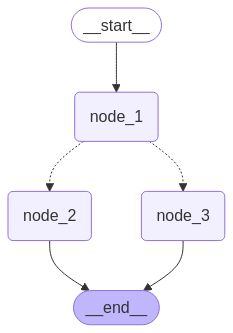

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build  graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic 
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

`Annotated` lets you attach extra metadata to a type without changing the base type. In this case:
- Base type: `list`
- Metadata: `add_messages` (a function that defines how this field should be updated)

LangGraph uses this to know **how to merge or update this state key** during execution.


`TypedDict` defines a dictionry where each key has a known type.

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

- `State`: A shared data structure that represents the current snapshot of our application. It can be any Python type but its typically a `TyepDict` or Pydantic `BaseModel`
- `Nodes`: Python functions can encode the logic of our agents. They receive the current `State` as an input, perform some computation and return an updated `State`
- `Edges`: Python functions that determine `Node` to execute next based on the current `State`. They can be conditional branches or fixed transitions.


The real power comes from how LangGraph manges `State`. To emphasize: `Nodes` and `Edges` are nothing more than Python functions. 

In short: nodes do the work and edges tell what to do next.

In [10]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key 'messages'

In [11]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

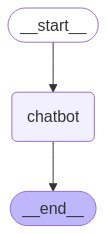

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  I'm really new to lang graph tbh, can you help me develop a better understanding it?


Assistant: It sounds like you might be referring to a tool or framework that uses a graph‐oriented approach to building language model applications (sometimes called “LangGraph”). (If you’re referring to a different “lang graph,” let me know!) Assuming that you mean something like the emerging libraries that let you build pipelines or workflows for language model operations via nodes and edges, here’s an overview to help you get started.

1. What Is a LangGraph?
 • The basic idea is to represent your application’s logic as a graph where each node is a distinct “operation” or “step” (for example, a prompt to a language model, a data transformation, or a decision point), and the edges indicate how data flows from one step to the next.
 • This approach lends itself to a visual, modular, and easily debuggable design. Instead of one long chain of function calls, you get a “map” of how input moves through multiple processing steps.

2. Why Use a Graph-Based Approach for Language Models?
 • V

User:  quit


Goodbye!
